# Perform Integration2d 

## save in format for xrd_fit

In [1]:
from nexusformat.nexus import *
import pyFAI, fabio, h5py
import numpy as np
import glob, os, os.path
from ipywidgets import Button, Layout, Dropdown
import itertools
import csv
import logging 
import math
import pathlib
import warnings
import pickle
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm

In [2]:
# Define paths
processing_dir = r"Z:\Diamond_MG28894-1_DATA_BACKUP\processing"
data_dir = r'Z:\Diamond_MG28894-1_DATA_BACKUP\rawdata'
output_dir = "\Integrated"

ponifile_1050mm = processing_dir + "\MG28894-1_poni_1050.poni"
ponifile_2350mm = processing_dir + "\MG28894-1_poni_2350.poni"
ponifile_750mm = processing_dir + "\MG28894-1_poni_750.poni"

In [3]:
# List the directories in the root directory, newest first

dir_list=[name.split('\\')[-1].split(".")[0] for name in sorted(glob.glob(data_dir + '\*.nxs'))]
drop_down = Dropdown(options=dir_list, value=dir_list[0], description='scanID:', disabled=False, 
                             layout=Layout(width='40%'), style={'description_width': 'initial'})

def dropdown_handler(change):
    global scanID
    scanID = change.new
drop_down.observe(dropdown_handler, names='value')
display(drop_down)

Dropdown(description='scanID:', layout=Layout(width='40%'), options=('108708', '108709', '108710', '108711', '…

In [119]:
fpath = data_dir + "\\" + scanID + "-pilatus2M-files" + "\\" 
fpath_subtracted = "..\\sxrd-tiff-summer\\example-results\\108800\\"
frame_format = ".tif"

In [121]:
# supress warnings when TIFFs are read
logging.getLogger("fabio.TiffIO").setLevel(logging.ERROR)

In [122]:
def safe_open_w(path):
    ''' Open "path" for writing, creating any parent directories as needed.
    '''
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return open(path, 'w')

In [ ]:
ponifile_1050mm = processing_dir + "/MG28894-1_poni_1050.poni"
ai = pyFAI.load(ponifile_1050mm)

In [123]:
ponifile_2350mm = processing_dir + "/MG28894-1_poni_2350.poni"
ai = pyFAI.load(ponifile_2350mm)

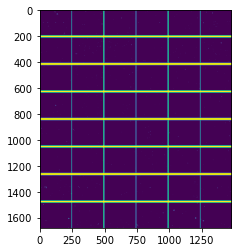

In [113]:
#load mask
mask_fname = processing_dir + "/mask_" + str(2350) + ".edf"
mask = fabio.open(mask_fname)
mask = mask.data
plt.imshow(mask)

[[0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 0 0]]


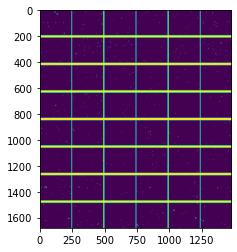

In [11]:
from scipy.ndimage.morphology import binary_dilation

dilated_mask = binary_dilation(mask)
plt.imshow(dilated_mask)
image_array = np.array(dilated_mask, dtype='int8')
print(image_array)

## Function to sum .tiff images to increase processing speed

## might be worth adding in the background subtraction to this automatically

In [147]:
def bin_imgs(input_path, output_path, bin_num, bkgd_file):
    image_list = sorted(pathlib.Path(input_path).glob("*.tif"))
    
    for image in tqdm(image_list[::bin_num]):
        ### setup image of zero values ###
        image_example = fabio.open(image_list[0])
        image_array = np.zeros(shape=np.shape(image_example.data), dtype='int32')

        ### set binning start & stop filenumbers ###
        image_num = image.stem.split("_")[-1]
        start = int(image_num)
        stop = int(image_num) + bin_num

        ### sum images in bin range ### 
        for index in list(range(start, start + bin_num)):
            fname = input_path + f"{int(index):05.0f}" + ".tif"
            try: 
                image_array = image_array + np.array(fabio.open(fname).data)
            except (FileNotFoundError):
                print("File: ", index, " not found - probably end of test")            
            
        ### subtract background ###
        background = fabio.open(bkgd_file).data
        image_array = image_array - background*bin_num*0.75

        ### save to location ###
        output_fname = output_path + "\\" + scanID + f"_binned\\{int(start+bin_num/2):05.0f}" + ".tif"
        
        # check if the output directory exists and if not create it
        CHECK_FOLDER = os.path.isdir(f"{output_path}")

        if not CHECK_FOLDER:
            os.makedirs(f"{output_path}")
#             print(f"Created folder : '{output_path}'.")

#         else:
#             print(f"'{output_path}' folder already exists.")

        # save the image
#         with safe_open_w(output_fname) as output:
        io.imsave(output_fname, image_array, check_contrast=False)

In [145]:
P_Diamond_air = r"Z:\Diamond_MG28894-1_DATA_BACKUP\rawdata\108801-pilatus2M-files\00001.tif"
output_dir = r"Z:\Diamond_MG28894-1_PROCESSING\Diamond_stacked_data"

bin_imgs(fpath, output_dir, 10, P_Diamond_air)

100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [02:20<00:00,  2.10s/it]


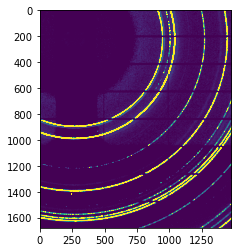

In [149]:
### check binning function ###

bin_test = io.imread(output_dir + "\\" + scanID + "_binned\\00026.tif")

plt.imshow(bin_test, vmin=0, vmax=500)

In [107]:
image_list = sorted(pathlib.Path(fpath_subtracted + "\\binned2").glob("*.tif"))
# image_list

In [166]:
print("integrating: ", scanID)    

# user inputs
number_of_points = 4000
number_of_cakes = 36

# rotate the detector so that the cardinal direction is in the center of the first cake.
first_cake_angle = 360 / number_of_cakes
ai.rot3 = (first_cake_angle / 2) * (math.pi / 180) # convert rotation to radians

# get a list of the files
image_list = sorted(pathlib.Path(fpath_subtracted + "\\binned2").glob("*.tif"))

for image_path in tqdm(image_list):
    # create empty array
    caked_data = np.zeros((number_of_cakes + 1, number_of_points))

    # create an image array and cake the data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        image = fabio.open(image_path)
    pattern_image_array = image.data
    pattern_image_array[pattern_image_array<0] = 0
#     mask = pattern_image_array < 1
    result2d = ai.integrate2d(pattern_image_array,
                            number_of_points,
                            number_of_cakes,
                            radial_range = (2, 6.5),
                            unit="2th_deg",
                            polarization_factor=0.99,
                            method='full_csr',
                            mask=mask,
                            dummy=np.nan
                            )

    # flip the intensity data to order cakes clockwise rather than anticlockwise
    intensity = np.flip(result2d.intensity.T, axis=1)

    # reshape radial labels to 2D array so they can be attached to the intensity data.
    radial = np.reshape(result2d.radial, (-1, 1))

    result_array = np.hstack((radial, intensity))

    # write out the caked data to a text file
    fname = image_path.stem.split("_")[-1]
#     output_path = r"Z:/Diamond_MG28894-1_DATA_BACKUP/processing/Integrated/0pt8_mask_" + scanID + "/12cake_" + f"{fname}.txt"
    output_path = r"Z:\Diamond_MG28894-1_PROCESSING\Diamond_stacked_data" + "\\" + scanID + "_mask0pt75_non_dil\\" + f"{fname}.txt"    
#     print(output_path)
    with safe_open_w(output_path) as output:
        np.savetxt(output, result_array, delimiter='\t')
        
print("Done \n")

  0%|                                                                                           | 0/71 [00:00<?, ?it/s]

integrating:  108799


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:57<00:00,  1.24it/s]

Done 



In [164]:
%matplotlib notebook 

output_path = r"Z:\Diamond_MG28894-1_PROCESSING\Diamond_stacked_data" + "\\" + scanID + "_mask0pt75_non_dil\\00356.txt"

data = np.loadtxt(output_path)

<IPython.core.display.Javascript object>


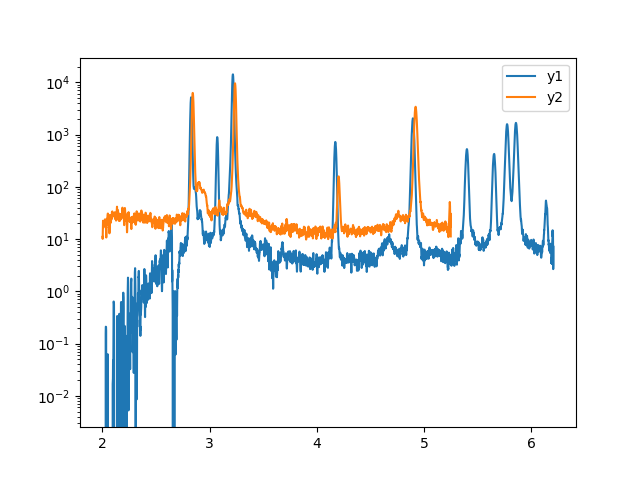

In [165]:
x = data[:,0]
y1 = data[:,9]
y2 = data[:,18]

# plt.plot(x, y, label="y")
plt.plot(x, y1, label="y1")
plt.plot(x, y2, label="y2")
# plt.plot(x, y3, label="y3")
plt.yscale("log")
plt.legend()

In [7]:
with open('Diamond_experiments.pkl', 'rb') as f:
    Samples = pickle.load(f)

In [ ]:
# user inputs
number_of_points = 4000
number_of_cakes = 36

In [30]:
for sample, info in dict(itertools.islice(Samples.items(), 3, len(Samples))).items():
    scanID = str(info[0])
    print("integrating: ", sample, "\n\t scanID: ", scanID)    
    
    #load ponifile
    # poni_fname = processing_dir + "\MG28894-1_poni_" + str(2350) + ".poni"
    poni_fname = processing_dir + "/MG28894-1_poni_" + str(info[3]) + ".poni"
    ai = pyFAI.load(poni_fname)
    
    #load mask
    mask_fname = processing_dir + "/mask_" + str(info[3]) + ".edf"
    mask = fabio.open(mask_fname)
    mask = mask.data
    print("\t mask: ", mask_fname.split("/")[-1])

    # rotate the detector so that the cardinal direction is in the center of the first cake.
    first_cake_angle = 360 / number_of_cakes
    ai.rot3 = (first_cake_angle / 2) * (math.pi / 180) # convert rotation to radians

    # get a list of the files
    fpath = data_dir + "/" + scanID + "-pilatus2M-files" + "/" 
    print("\t rawdata Path: ", pathlib.Path(fpath).stem)
    image_list = sorted(pathlib.Path(fpath).glob("*.tif"))
    
    for image_path in image_list:
        # create empty array
        caked_data = np.zeros((number_of_cakes + 1, number_of_points))

        # create an image array and cake the data
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            image = fabio.open(image_path)
        pattern_image_array = image.data
        result2d = ai.integrate2d(pattern_image_array,
                                number_of_points,
                                number_of_cakes,
                                radial_range = (2.5, 6.5),
                                unit="2th_deg",
                                polarization_factor=0.99,
                                method='full_csr',
                                mask=mask, 
                                dummy=np.nan
                                 )

        # flip the intensity data to order cakes clockwise rather than anticlockwise
        intensity = np.flip(result2d.intensity.T, axis=1)

        # reshape radial labels to 2D array so they can be attached to the intensity data.
        radial = np.reshape(result2d.radial, (-1, 1))

        result_array = np.hstack((radial, intensity))

        # write out the caked data to a text file
        output_path = r"Z:/Diamond_MG28894-1_DATA_BACKUP/processing/Integrated/" + scanID + "/" + f"{image_path.stem}.txt"
        output_path = output_dir + "/" + str(scanID) + "/" + f"{image_path.stem}.txt"
#         print("Saving to: ", scanID + "/" + f"{image_path.stem}.txt")
        with safe_open_w(output_path) as output:
            np.savetxt(output, result_array, delimiter='\t')
    print("Done \n")

integrating:  Zr4_RD_AC_AD_far 
	 scanID:  108799
	 mask:  mask_2350.edf
	 rawdata Path:  108799-pilatus2M-files


KeyboardInterrupt: 